In [ ]:
!pip install datasets &> /dev/null
!pip install transformers &> /dev/null
!pip install evaluate &> /dev/null
!pip install bert_score &> /dev/null
!pip install sentencepiece &> /dev/null
!pip install torch torchvision &> /dev/null
!pip install accelerate &> /dev/null
!pip install trl &> /dev/null

import datasets
import numpy as np
import torch
import random
import tensorflow as tf
import tensorflow_hub as hub
import torch.nn.functional as F
import itertools

from evaluate import load
from transformers import pipeline, AutoTokenizer, BertForQuestionAnswering, BertTokenizer
from datasets import load_dataset
from huggingface_hub import notebook_login
from trl import AutoModelForCausalLMWithValueHead, AutoModelForSeq2SeqLMWithValueHead

# Check if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
SQuAT_database = load_dataset('squad', split='validation')

baseline_summarizer = AutoModelForSeq2SeqLMWithValueHead.from_pretrained("KrijnD/flan-t5-base-cnn_dailymail").to(device)
pragmatic_summarizer = AutoModelForSeq2SeqLMWithValueHead.from_pretrained("KrijnD/flan-t5-base_with_pragmatics_all_costs_100_epoch").to(device)

# tokenizer is the same with the pragmatic and baseline model so only one is used
tokenizer = AutoTokenizer.from_pretrained("KrijnD/flan-t5-base-cnn_dailymail")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


Some weights of the model checkpoint at KrijnD/flan-t5-base_with_pragmatics_all_costs_100_epoch were not used when initializing T5ForConditionalGeneration: ['v_head.summary.weight', 'v_head.summary.bias']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Initialize the model and tokenizer for question answering
BERT_model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad').to(device)
BERT_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [ ]:
# download embeddings for bert to compute utility
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def rand_index(database):
    """
    creates a randomized index with max range of the specified database
    """
    if database == 'squat':
        random_index = random.randint(0, 10600)

    elif database == 'duorc':
        random_index = random.randint(0, 12559)

    elif database == 'mlqa':
        random_index = random.randint(0, 4520)

    else:
        raise ValueError("database must be:'squat' or 'duorc'")

    return random_index


def get_article(database, context_index):
    """
    this function retrieves the context, question, answer and id's from a
    database, based on the index, both the index and database are specified by
    the user: squat, duorc or mlqa
    """
    if database == 'squat':
        article = SQuAT_database[context_index]['context']
        question = SQuAT_database[context_index]['question']
        answers = SQuAT_database[context_index]['answers']['text']


    elif database == 'duorc':
        article = duorc_database['test'][context_index]['plot']
        question = duorc_database['test'][context_index]['question']
        answers = duorc_database['test'][context_index]['answers']
        context_id = duorc_database['test'][context_index]['plot_id']

    elif database == 'mlqa':
        article = mlqa_database['test']['context'][context_index]
        question = mlqa_database['test']['question'][context_index]
        answers = mlqa_database['test']['answers'][context_index]['text'][0]
        answers = mlqa_database['test']['id'][context_index]

    else:
        raise ValueError("database must be:'squat', 'duorc' or 'mlqa'")

    return article, question, answers[0]


# def answer_question(question, context, model=BERT_model, tokenizer=BERT_tokenizer):

#     # Tokenize the input
#     inputs = tokenizer.encode_plus(question, context, return_tensors='pt', truncation=True, max_length=512)

#     # Get the model's output
#     output = model(**inputs)

#     # Get the most likely beginning and end of answer with the argmax function
#     answer_start = torch.argmax(output.start_logits)
#     answer_end = torch.argmax(output.end_logits) + 1

#     # Get the input IDs
#     input_ids = inputs["input_ids"].tolist()[0]

#     # Convert ID to string and join all to form the answer.
#     answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

#     return answer


def get_topk_answers(question, context, model=BERT_model, tokenizer=BERT_tokenizer, k=2):
    """
    Takes a question and a context string along with a pretrained model and tokenizer.
    Returns the top-k answers according to the model.
    """

    # Encode the question and context
    encoding = tokenizer.encode_plus(question, context, return_tensors='pt', truncation=True, max_length=512).to(device)

    input_ids = encoding['input_ids']
    token_type_ids = encoding['token_type_ids']

    # Get the model output
    outputs = model(input_ids, token_type_ids=token_type_ids)

    # Obtain the start and end scores from the model output
    start_scores, end_scores = outputs.start_logits, outputs.end_logits

    # Get the top-k start and end scores
    start_topk_values, start_topk_indices = torch.topk(start_scores, k)
    end_topk_values, end_topk_indices = torch.topk(end_scores, k)

    all_answers = []
    for start in start_topk_indices[0]:
        for end in end_topk_indices[0]:
            if start <= end:  # They need to be in the proper order
                all_answers.append(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[0][start: end+1].tolist())))

    return all_answers

def word_count(string):
    words = string.split()
    return len(words)

In [ ]:
def answer_question(question, context, model=BERT_model, tokenizer=BERT_tokenizer):
    # Tokenize the input
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt', truncation=True, max_length=512)

    # Move your inputs to device
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}

    # Get the model's output
    output = model(**inputs)

    # Get the most likely beginning and end of answer with the argmax function
    answer_start = torch.argmax(output.start_logits)
    answer_end = torch.argmax(output.end_logits) + 1

    # Get the input IDs
    input_ids = inputs["input_ids"].tolist()[0]

    # Convert ID to string and join all to form the answer.
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    return answer

In [ ]:
def sentence_surprisal(context, sentence, model, tokenizer=tokenizer):
    """
    Process sentence with an LM and return the surprisal (negative log
    probability) of each token. Context and sentence are strings.
    Model and tokenizer are from the transformers library.
    """

    context_ids = tokenizer.encode(context, return_tensors='pt')
    sentence_ids = tokenizer.encode(sentence, return_tensors='pt')

    # Input: Join context and sentence
    # Note: special token may vary based on model and task!
    # input_ids = context_ids + [tokenizer.eos_token_id] + sentence_ids
    eos_token = torch.tensor([tokenizer.eos_token_id]).unsqueeze(0)
    input_ids = torch.cat([context_ids, eos_token, sentence_ids], dim=-1)


    # # Add a new dimension to input_ids for batch size
    # input_ids = input_ids.to(device)


    # Cut the input to the maximum length of the model
    # input_ids = input_ids[- model.config.n_positions:]
    input_ids = input_ids[:, :model.config.n_positions]

    # Add a new dimension to input_ids for batch size
    # input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
    input_ids = input_ids.to(device)

    # Adjust the length of context_ids if it has been truncated
    context_ids = context_ids[- model.config.n_positions:-len(sentence_ids)-1]


    # Keep model frozen during surprisal computations
    with torch.no_grad():
        # Forward pass
        outputs = model(input_ids=input_ids, decoder_input_ids=input_ids)

        logits = outputs[0]
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)

        # Get the log probability for each token in the sentence
        token_log_probs = log_probs[0,
            range(len(context_ids), len(context_ids) + len(sentence_ids)), sentence_ids
        ]

        # Transform into surprisal (for each token in the sentence)
        token_surprisal = - token_log_probs

    return token_surprisal


In [ ]:
def answer_probability(summary,
                       question,
                       answer,
                       model,
                       tokenizer=tokenizer):
    """
    takes three strings (the summary, question, and answer), a T5 model, and a
    tokenizer. It converts each of the strings to tensors of token IDs,
    concatenates these into a single tensor, and feeds this to the model. It
    then retrieves the log probabilities of the answer tokens and converts these
    to actual probabilities.

    """

    summary_ids = tokenizer.encode(summary, return_tensors='pt')
    question_ids = tokenizer.encode(question, return_tensors='pt')
    answer_ids = tokenizer.encode(answer, return_tensors='pt')

    # Input: Join summary, question, and answer
    input_ids = torch.cat([summary_ids, question_ids, answer_ids], dim=-1)

    # Cut the input to the maximum length of the model
    input_ids = input_ids[:, :model.config.n_positions]

    # Add a new dimension to input_ids for batch size
    input_ids = input_ids.to(device)

    # Adjust the length of summary_ids and question_ids if they have been truncated
    summary_length = min(summary_ids.size(-1), model.config.n_positions - question_ids.size(-1) - answer_ids.size(-1))
    question_length = min(question_ids.size(-1), model.config.n_positions - summary_length - answer_ids.size(-1))

    # Keep model frozen during surprisal computations
    with torch.no_grad():
        # Forward pass
        outputs = model(input_ids=input_ids, decoder_input_ids=input_ids)

        logits = outputs[0]
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)

        # Get the log probability for each token in the answer
        log_token_probs = log_probs[0,
            range(summary_length + question_length, summary_length + question_length + answer_ids.size(-1)),
            input_ids[0, summary_length + question_length:summary_length + question_length + answer_ids.size(-1)]
        ]

        # Transform log probabilities into actual probabilities
        token_probs = torch.exp(log_token_probs)

        answer_probability = float(torch.mean(token_probs))

    return round(answer_probability, 3)

In [ ]:
def encoding_cost(context, model, tokenizer=tokenizer):
    """
    mean of sub-word token surprisals of the summarizer model reading the
    original text for each

    """
    context_surprisal = sentence_surprisal("", context, model, tokenizer)

    return  torch.mean(context_surprisal)


In [ ]:
def realisation_cost(context, summary, model, tokenizer=tokenizer):
    """
    utterance length and mean of sub-word token surprisals of the summarizer model reading the
    summary and having the context as previous text.

    """
    summary_surprisal = sentence_surprisal(context, summary, model, tokenizer)
    utterance_length = word_count(summary)

    return torch.mean(summary_surprisal), utterance_length

In [ ]:
import math

def decoding_cost_v2(summary, question, pred_answer, model):
    probs_candidate_answers = []

    alt_answers = get_topk_answers(question, summary)

    # calculate the probability of the predicted answer
    prob_predicted_answer = answer_probability(summary,
                                                question,
                                                pred_answer,
                                                model)

    # calculating decoding cost as:
    # mean(probability of candidate answers)/probability of predicted answer

    # check if there are any other probable answers
    # if not that means that the decoding costs are very high.
    #  in that case the decoding cost becomes 3 times the average (1.21)
    if not alt_answers:
        dec_cost = 3.63

    else:
        # calculate the probabilities of the candidate answers/responces
        for ans in alt_answers:
            probs_candidate_answers.append(answer_probability(summary,
                                                                question,
                                                                ans,
                                                                model))
        # avoid dividing by 0
        if math.isclose(prob_predicted_answer, 0.0):
            dec_cost =  np.mean(probs_candidate_answers)/0.01

        else:
            dec_cost = np.mean(probs_candidate_answers)/prob_predicted_answer

    return dec_cost

In [ ]:
def utility(predicted_answer, real_answer):
    """
    This function calculates the utility of a predicted answer by comparing it
    with the real answer using the universal sentence decoder.
    """
    sentences = [
    real_answer,
    predicted_answer,
    ]
    # Use the model to embed the sentences
    encoding_matrix = embed(sentences)

    # Calculate the inner product of the embeddings
    similarity_score = np.inner(encoding_matrix, encoding_matrix)[0, 1]

    return similarity_score

In [ ]:
def get_pragmatic_costs(context, question, answer, summary, model):
    predicted_answer = answer_question(question, summary)

    enc_cost = encoding_cost(context, model)
    real_cost = realisation_cost(context, summary, model)
    dec_cost_v2 = decoding_cost_v2(summary, question, predicted_answer, model)
    util = utility(predicted_answer, answer)
    utterance_len = real_cost[1]

    return enc_cost, real_cost[0], utterance_len, dec_cost_v2, util

In [ ]:
def compute_reward_post(context, question, answer, summary):
    enc_cost, real_cost, utterance_len, dec_cost_v2, util = get_pragmatic_costs(context, question, answer, summary)

    enc_cost /= 10
    real_cost /= 10
    utterance_len /= 60
    util *= 4

    reward = util - (enc_cost + real_cost + dec_cost_v2 + utterance_len)
    return reward, util/4

In [ ]:
import pandas as pd
from datasets import load_dataset

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, ds):
        self.ds = ds

    def __getitem__(self, idx):
        return self.ds[idx]

    def __len__(self):
        return self.ds.num_rows

def tokenize(sample):
    sample["context_ids"] = tokenizer.encode(sample["context"],
                                             max_length=512,
                                             truncation=True,
                                             padding='max_length')
    sample["context_ids"] = torch.tensor(sample["context_ids"])

    encoded = sample["context_ids"]
    # Check the length of the encoded sequence
    assert len(encoded) == 512, f"Encoded sequence length was {len(encoded)}, expected 512."

    sample["answers"] = sample["answers"]["text"][0]
    return sample

# Load the dataset
ds = load_dataset('squad', split="validation")

# Tokenize the dataset
ds = ds.map(tokenize, batched=False)
ds.set_format(type="torch")

# Create a custom dataset
dataset_preprocessed = CustomDataset(ds)

In [ ]:
generation_kwargs = {
    "num_beams": 4,
    "max_length": 512,
    # "repetition_penalty": 2.5,
    # "length_penalty": 1.0,
    # "early_stopping": True
}

In [ ]:
#### get a batch from the dataset_preprocessed
bs = 150

# Initialize DataLoader
data_loader = torch.utils.data.DataLoader(dataset_preprocessed, batch_size=bs, shuffle=True)

# Get a single batch
data_batch = next(iter(data_loader))

# Create summary data dict
summary_data = dict()
summary_data["context"] = [context for context in data_batch["context"]]
context_tensors = [context_ids.cpu() for context_ids in data_batch["context_ids"]]

response_tensors_ref, response_tensors = [], []

#### get response from gpt2 and gpt2_ref
for i in range(bs):
    output = baseline_summarizer.generate(context_tensors[i].unsqueeze(0).to(device), **generation_kwargs)
    response_tensors_ref.append(output.squeeze(0).cpu())

    output = pragmatic_summarizer.generate(context_tensors[i].unsqueeze(0).to(device), **generation_kwargs)
    response_tensors.append(output.squeeze(0).cpu())

#### decode responses
summary_data["summary (before finetunning)"] = [tokenizer.decode(response_tensors_ref[i], skip_special_tokens=True, clean_up_tokenization_spaces=False) for i in range(bs)]
summary_data["summary (after finetunning)"] = [tokenizer.decode(response_tensors[i], skip_special_tokens=True, clean_up_tokenization_spaces=False) for i in range(bs)]

# get data from batch
contexts_res = summary_data["context"]
questions_res = data_batch["question"]
answers_res = data_batch["answers"]

# Initialize an empty list to store the cost and utility values for each summary
costs_and_utils_before = []
costs_and_utils_after = []

# Compute the costs and utility for each summary in the batch
for context, question, answer, summary_before, summary_after in zip(contexts_res, questions_res, answers_res, summary_data["summary (before finetunning)"], summary_data["summary (after finetunning)"]):
    cost_before = get_pragmatic_costs(context, question, answer, summary_before, baseline_summarizer)
    cost_before = (cost_before[0].item(), cost_before[1].item(), cost_before[2], cost_before[3], cost_before[4])
    costs_and_utils_before.append(cost_before)

    cost_after = get_pragmatic_costs(context, question, answer, summary_after, pragmatic_summarizer)
    cost_after = (cost_after[0].item(), cost_after[1].item(), cost_after[2], cost_after[3], cost_after[4])
    costs_and_utils_after.append(cost_after)

# Store the results in the summary_data dictionary
summary_data["enc_cost (before)"], summary_data["real_cost (before)"], summary_data["utterance_len (before)"], summary_data["dec_cost_v2 (before)"], summary_data["utility (before)"] = zip(*costs_and_utils_before)
summary_data["enc_cost (after)"], summary_data["real_cost (after)"], summary_data["utterance_len (after)"], summary_data["dec_cost_v2 (after)"], summary_data["utility (after)"] = zip(*costs_and_utils_after)

# Convert the dictionary to a DataFrame
df_results = pd.DataFrame(summary_data)

# rearanging order
df_results = df_results[[
    'context', 'summary (before finetunning)', 'summary (after finetunning)', 'enc_cost (before)', 'enc_cost (after)',
    'real_cost (before)', 'real_cost (after)', 'utterance_len (before)', 'utterance_len (after)',
    'dec_cost_v2 (before)', 'dec_cost_v2 (after)', 'utility (before)', 'utility (after)'
]]

df_results

,context,summary (before finetunning),summary (after finetunning),enc_cost (before),enc_cost (after),real_cost (before),real_cost (after),utterance_len (before),utterance_len (after),dec_cost_v2 (before),dec_cost_v2 (after),utility (before),utility (after)
0,The working fluid in a Rankine cycle can opera...,The working fluid in a Rankine cycle can opera...,The working fluid in a Rankine cycle can opera...,11.007470,12.051931,9.939160,10.151556,63,68,0.468750,0.468750,0.342329,1.000000
1,The Royal Geographical Society of London and o...,The Royal Geographical Society of London and o...,The Royal Geographical Society of London and o...,14.166071,13.905045,10.503424,10.628741,63,63,1.050000,1.200000,0.066413,0.066413
2,The Taliban were spawned by the thousands of m...,The Taliban were spawned by the thousands of m...,The Taliban were spawned by the thousands of m...,12.243385,13.581486,8.354156,8.505466,57,51,0.950000,0.659091,0.158833,1.000000
3,Parliamentary time is also set aside for quest...,"A ""General Question Time"" takes place on a Thu...","A ""General Question Time"" takes place on a Thu...",10.436645,11.836831,6.662633,6.816060,58,58,3.300000,3.150000,0.091813,0.091813
4,The movement which would become The United Met...,The movement which would become The United Met...,The movement which would become The United Met...,9.958548,10.554976,8.356463,8.545916,71,75,0.900000,0.800000,0.210387,0.210387
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,"From 2005 to 2014, there were two Major League...",Two Major League Soccer teams in Los Angeles —...,"From 2005 to 2014, there were two Major League...",12.354178,12.803319,13.116016,11.642050,45,53,1.333333,1.000000,1.000000,1.000000
146,Hypersensitivity is an immune response that da...,Hypersensitivity is an immune response that da...,Hypersensitivity is an immune response that da...,14.117846,14.127946,8.076783,8.076867,76,76,0.812500,0.907895,0.246767,0.246767
147,The Saturn IB was an upgraded version of the S...,The Saturn IB was an upgraded version of the S...,The Saturn IB was an upgraded version of the S...,9.922644,10.269114,8.987230,8.517735,67,52,1.535714,0.500000,1.000000,1.000000
148,A conservative force that acts on a closed sys...,A conservative force that acts on a closed sys...,A conservative force that acts on a closed sys...,11.607035,12.479606,10.123178,10.401138,89,67,1.500000,0.708333,1.000000,1.000000


In [ ]:
columns_to_compute = ["enc_cost (before)", "enc_cost (after)",
                      "real_cost (before)", "real_cost (after)",
                      "utterance_len (before)", "utterance_len (after)",
                      "dec_cost_v2 (before)", "dec_cost_v2 (after)",
                      "utility (before)", "utility (after)"]

mean_values = df_results[columns_to_compute].mean()
median_values = df_results[columns_to_compute].median()

print("Mean values:")
print(mean_values)

print("\nMedian values:")
print(median_values)


Mean values:
enc_cost (before)         12.373457
enc_cost (after)          13.012861
real_cost (before)         9.732707
real_cost (after)          9.895523
utterance_len (before)    61.986667
utterance_len (after)     57.833333
dec_cost_v2 (before)       1.614507
dec_cost_v2 (after)        1.263149
utility (before)           0.569040
utility (after)            0.596111
dtype: float64

Median values:
enc_cost (before)         12.318218
enc_cost (after)          13.132079
real_cost (before)         9.524290
real_cost (after)          9.579272
utterance_len (before)    61.000000
utterance_len (after)     58.000000
dec_cost_v2 (before)       0.943750
dec_cost_v2 (after)        0.905506
utility (before)           0.544491
utility (after)            0.634558
dtype: float64


In [ ]:
# Calculation for Mean values
mean_diff = mean_values.loc[[col for col in mean_values.index if 'after' in col]].values - mean_values.loc[[col for col in mean_values.index if 'before' in col]].values
mean_percentage_change = (mean_diff / mean_values.loc[[col for col in mean_values.index if 'before' in col]].values) * 100

mean_percentage_change = pd.Series(mean_percentage_change, index=[col.replace(' (after)', '') for col in mean_values.index if 'after' in col])

print("Percentage change in Mean values:")
print(mean_percentage_change)

# Calculation for Median values
median_diff = median_values.loc[[col for col in median_values.index if 'after' in col]].values - median_values.loc[[col for col in median_values.index if 'before' in col]].values
median_percentage_change = (median_diff / median_values.loc[[col for col in median_values.index if 'before' in col]].values) * 100

median_percentage_change = pd.Series(median_percentage_change, index=[col.replace(' (after)', '') for col in median_values.index if 'after' in col])

print("\nPercentage change in Median values:")
print(median_percentage_change)


Percentage change in Mean values:
enc_cost          5.167541
real_cost         1.672875
utterance_len    -6.700366
dec_cost_v2     -21.762561
utility           4.757356
dtype: float64

Percentage change in Median values:
enc_cost          6.606973
real_cost         0.577289
utterance_len    -4.918033
dec_cost_v2      -4.052349
utility          16.541566
dtype: float64


In [ ]:
correlation = df_results[["enc_cost (after)",
                          "real_cost (after)",
                          "utterance_len (after)",
                          "dec_cost_v2 (after)",
                          "utility (after)"]].corr()

# Drop 'utility (after)' correlation
correlation = correlation.drop("utility (after)")

print(correlation['utility (after)'])


enc_cost (after)        -0.082721
real_cost (after)       -0.029529
utterance_len (after)    0.091491
dec_cost_v2 (after)     -0.108238
Name: utility (after), dtype: float64


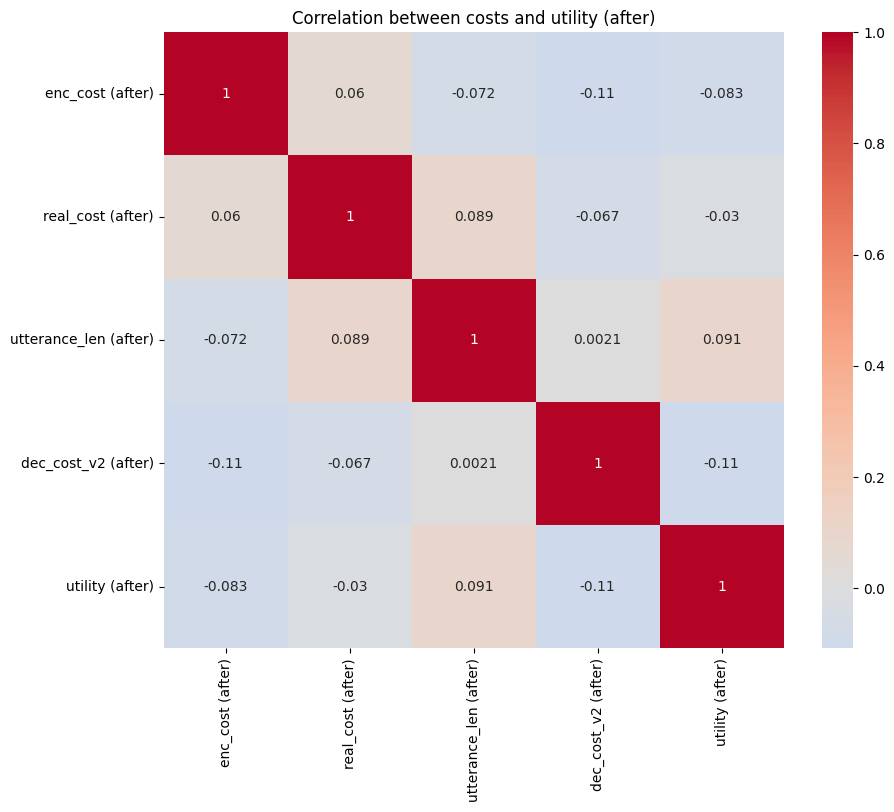

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation = df_results[["enc_cost (after)",
                          "real_cost (after)",
                          "utterance_len (after)",
                          "dec_cost_v2 (after)",
                          "utility (after)"]].corr()

plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)  # Create the heatmap

plt.title('Correlation between costs and utility (after)')
plt.show()


In [ ]:
import plotly.figure_factory as ff

# Rename the columns
df_results = df_results.rename(columns={
    "enc_cost (after)": "Encoding cost after training",
    "real_cost (after)": "Realisation cost after training",
    "utterance_len (after)": "Utterance length after training",
    "dec_cost_v2 (after)": "Decoding cost after training",
    "utility (after)": "Utility after training"
})

correlation = df_results[["Encoding cost after training",
                          "Realisation cost after training",
                          "Utterance length after training",
                          "Decoding cost after training",
                          "Utility after training"]].corr()

# Convert DataFrame to matrix
correlation_matrix = correlation.values

# Get column names
columns = correlation.columns.to_list()

# Create the heatmap
heatmap = ff.create_annotated_heatmap(correlation_matrix, x=columns, y=columns,
                                      colorscale='Viridis',  # You can change this colorscale
                                      annotation_text=correlation_matrix.round(2))

# Adjust title and label size and position
heatmap.update_layout(height=600, width=730,
                      title_text='Correlation between costs and utility after training',
                      title_x=0.5,
                      title_y=1,
                      title_font=dict(size=18),  # Adjust as needed
                      font=dict(size=12, family="Courier New"),
                      autosize=True)

heatmap.update_xaxes(tickangle=18, tickfont=dict(size=12, family="Courier New"))  # Adjust as needed
heatmap.update_yaxes(tickfont=dict(size=12, family="Courier New"))  # Adjust as needed

heatmap.show()


In [ ]:
df_results.to_excel('data_learning_all_costs_100_epoch.xlsx', index=False)